In [2]:
import pandas as pd
import numpy as np
import pymc3 as pm
from statsmodels.formula.api import glm 
import scipy
import matplotlib.pyplot as plt
import arviz as az

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\users\aaron\appdata\local\programs\python\python38\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


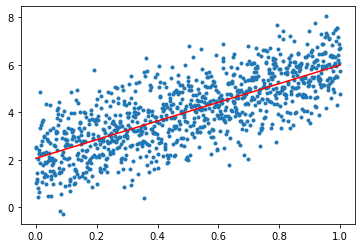

In [3]:
#generate some fake data
size = 1000
true_intercept = 2
true_slope = 4
x = np.linspace(0, 1, size)
y = true_intercept + x*true_slope + np.random.normal(scale=1, size=size)

# least squares regression
def leastsquares(x,y):
    x_mean=np.mean(x)
    y_mean=np.mean(y)
    num=0
    den=0
    for i in range(len(x)):
        num+= (x[i]-x_mean)*(y[i]-y_mean)
        den += (x[i]-x_mean)**2
    m= num/den
    c=y_mean- m*x_mean
    return m,c
m,c=leastsquares(x,y)
# make predictions

y_pred = m*x +c
plt.plot(x,y,'.')
plt.plot([min(x), max(x)],[min(y_pred),max(y_pred)],color='red')

In [5]:
data={"x":x,"y":y}
with pm.Model() as linear_model:
    lm=pm.glm.linear.LinearComponent.from_formula("y~x",data)
    #priors
    sigma=pm.Uniform('sigma', 0, 30)
    y_obs = pm.Normal("y_obs", mu=lm.y_est, sigma=sigma, observed=y)
    #inference
    trace=pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, x, Intercept]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 78 seconds.
The acceptance probability does not match the target. It is 0.8843088597810529, but should be close to 0.8. Try to increase the number of tuning steps.


In [6]:
inference_data = az.from_pymc3(trace)
az.summary(inference_data)

c:\users\aaron\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,2.057,0.065,1.932,2.177,0.001,0.000,8805.0,8805.0,8827.0,9112.0,1.0
x,3.931,0.113,3.720,4.147,0.001,0.001,8770.0,8768.0,8786.0,8290.0,1.0
sigma,1.012,0.023,0.970,1.055,0.000,0.000,11645.0,11643.0,11637.0,11087.0,1.0


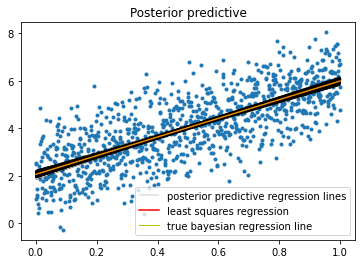

In [11]:
plt.plot(x,y,".")

pm.plot_posterior_predictive_glm(trace,samples=1000, eval=x, label="posterior predictive regression lines")
plt.plot([min(x), max(x)],[min(y_pred),max(y_pred)],color='red', label="least squares regression")
plt.plot(x, trace['Intercept'].mean() + trace['x'].mean()*x, label='true bayesian regression line', lw=1., c='y')
plt.legend(loc=0)